Now let us do a very systematic study of the Pendulum

In [1]:
from autoencoder import *

This is the trivial dataset for the pendulum:

In [2]:
theta = np.linspace(-np.pi,0.0*np.pi,500, dtype=np.float32)
data = np.vstack([np.cos(theta), np.sin(theta)]).T

This class is a container object for solving the DAE on top of an autoencoder

In [13]:
class Mechanics():
    def __init__(self, au):
        # inputs
        i_q0 = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
        i_v0 = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
        i_qi = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
        i_vi = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
        Dt = tf.constant(0.05)
        aii = 0.5
        g = tf.constant(9.81)
        # the lagrangian
        def L(i_q,i_v):
            x = au.decode(i_q)
            dxdq = atu.vector_gradient_dep(x,i_q)
            v = tf.einsum("ikj,ij->ik",dxdq,i_v)
            L = 0.5*tf.einsum("ij,ij->i",v,v) - g*x[:,1]
            return x,v, tf.expand_dims(L,-1)
        # The pieces to the diff eq
        o_x,o_v,Li = L(i_qi,i_vi)
        dLi_dv = atu.vector_gradient_dep(Li,i_vi)
        dLi_dq = atu.vector_gradient_dep(Li,i_qi)
        _,_,L0 = L(i_q0,i_v0)
        dL0_dv = atu.vector_gradient_dep(L0,i_v0)
        dL0_dq = atu.vector_gradient_dep(L0,i_q0)
        # the trapezoidal rungekutta
        lhs = dLi_dv - Dt * aii * dLi_dq
        rhs = dL0_dv + Dt * (1.0-aii) * dL0_dq
        KV = atu.vector_gradient_dep(lhs,i_vi)
        KQ = atu.vector_gradient_dep(lhs,i_qi)
        Ktot = Dt*KQ + KV
        self.i_qi,self.i_vi, self.i_q0, self.i_v0 = i_qi,i_vi, i_q0, i_v0
        self.o_x,self.o_v = o_x, o_v
        self.rhs, self.lhs = rhs, lhs
        self.Ktot = Ktot
        self.Dt, self.aii = Dt, aii
        
    def solve(self,theta_0 = -0.9*np.pi/2.0):
        x_init = np.array([[np.cos(theta_0),np.sin(theta_0)]])
        qN = au.o_q.eval(feed_dict={au.i_x:x_init})
        q_i = np.array([[0.0]])
        v_i = np.array([[0.0]])
        q_0 = np.array([[0.0]])
        v_0 = np.array([[0.0]])
        series = []
        ev = lambda x : sess.run(x,feed_dict
                ={self.i_qi:q_i,self.i_q0:q_0, self.i_vi:v_i, self.i_v0:v_0})
        n_Dt = ev(self.Dt)
        for it in range(1000):
            rhs_0 = ev(self.rhs)
            for k in range(10):
                K_k,lhs_k= ev([self.Ktot,self.lhs])
                R = rhs_0 - lhs_k
                Dv = np.linalg.solve(K_k[0,:,:], R[0,:])
                v_i[:] += Dv
                q_i[:] = q_0 + n_Dt*((1.0-self.aii)*v_0 + self.aii*v_i)
                n = np.linalg.norm(Dv)
                if n<2.0e-7: break
                #print(k, n, q_0)
            v_0[:] = v_i[:]
            q_0[:] = q_i[:]
            series.append(np.r_[ it*n_Dt, q_0[0,0],v_0[0,0],ev(self.o_x)[0,:],ev(self.o_v)[0,:] ])
        series = np.c_[series]
        return series

In [14]:
graph = tf.Graph()
with graph.as_default():
    dataset = tf.data.Dataset.from_tensor_slices(data)
    tr_x = atu.make_datastream(dataset)
    au = PolyAutoencoder(2,1,tr_x, 2,5, encoder_init="dont")
    mech = Mechanics(au)
    init=tf.global_variables_initializer()

Making  enc_W
Making  enc_b
Making  dec_W
Making  dec_b
Fetching  enc_W
Fetching  enc_b
Fetching  dec_W
Fetching  dec_b
[<tf.Variable 'enc_W/Adam:0' shape=(5, 1) dtype=float32_ref>, <tf.Variable 'enc_b/Adam:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'dec_W/Adam:0' shape=(5, 2) dtype=float32_ref>, <tf.Variable 'dec_b/Adam:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'enc_W/Adam_1:0' shape=(5, 1) dtype=float32_ref>, <tf.Variable 'enc_b/Adam_1:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'dec_W/Adam_1:0' shape=(5, 2) dtype=float32_ref>, <tf.Variable 'dec_b/Adam_1:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>]
Fetching  enc_W
Fetching  enc_b
Fetching  dec_W
Fetching  dec_b
Fetching  enc_W
Fetching  enc_b
Fetching  dec_W
Fetching  dec_b
Fetching  dec_W
Fetching  dec_b
Fetching  dec_W
Fetching  dec_b


In [15]:
try:
    sess.close()
except:
    pass
sess = tf.InteractiveSession(graph=graph)
init.run(session=sess)

In [16]:
def plot_circle(au):
    qs = au.o_q.eval(feed_dict={au.i_x:data})
    xps = au.o_x.eval(feed_dict={au.i_q:qs})
    plt.plot(xps[:,0],xps[:,1])
    return xps

9 0.41351822
19 0.33019355
39 0.17904776
79 0.063265145
159 0.004096843
319 0.000945386
639 0.00010401597
1279 3.8812337e-05


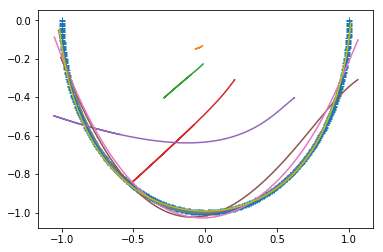

In [17]:
plt.plot(data[:,0],data[:,1],'+')
nxt_prnt = 10
serieses = []
for i in range(10*2**7):
    #train_step.run(session=sess)
    sess.run(au.train_step)
    if i%nxt_prnt==nxt_prnt-1:
        print(i,au.goal.eval(session=sess))
        serieses.append( mech.solve() )
        plot_circle(au)
        nxt_prnt *= 2

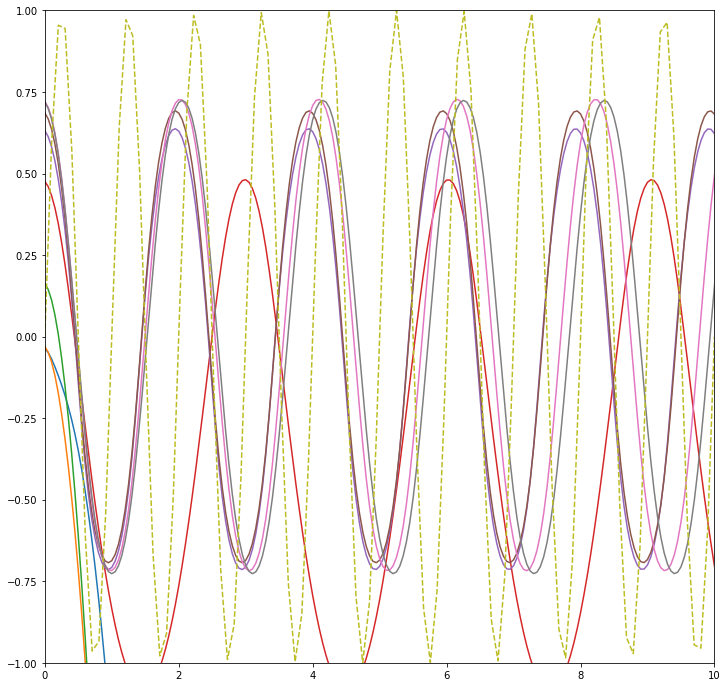

In [32]:
plt.figure(figsize=(12,12))
for series in serieses:
    plt.plot(series[:,0],series[:,3])
    plt.xlim( 0,10)
    plt.ylim(-1,1)
ts = np.linspace(0,10,100)
plt.plot(ts,np.sin(ts*(2*np.pi)),'--')

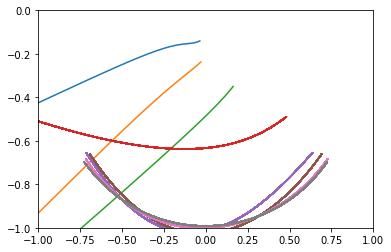

In [27]:
for series in serieses:
    plt.plot(series[:,3],series[:,4])
    plt.xlim(-1,1)
    plt.ylim(-1,0)